# Figure 05

Short description: This is mainly data prep

## Import libraries

In [1]:
import glob
import os
import pickle
import re
import string
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, LogNorm
from matplotlib.ticker import FuncFormatter
from scipy.stats import poisson

from calc_coalescence_densities import *
from travelling_wave_approach import *

print(imported())

True


## Parameters and functions

In [2]:
# parameters to calculate the expected times
time_parameters = dict(tmin=0, tmax=13_000, ndens=300)
assert time_parameters["tmin"] == 0, "Present time must be set to zero!"
time_full = np.arange(time_parameters["tmin"], time_parameters["tmax"])
time_psi = np.array(
    [time_parameters["tmin"]]
    + list(
        np.logspace(
            np.log10(1), np.log10(time_full.max()), num=time_parameters["ndens"]
        )
    )
)

In [3]:
# parameters to calculate the simulated coalescence density
time_nbin, time_Tmax, time_N = 20, 3, 5000  # for time bin definition
# define bins
bin_edges = time_intervals(nsam=time_nbin, max_tmrca=time_Tmax, popsize=2 * time_N)
bin_widths = np.diff(bin_edges)

In [4]:
def extract_values(filename):
    fsplit = re.split(r"/|_|,", filename.split(".gzip")[0])
    return tuple(
        map(
            float,
            [
                fsplit[fsplit.index("popsize") + 1],
                fsplit[fsplit.index("delmutrate") + 1],
                fsplit[fsplit.index("selcoeff") + 1],
            ],
        )
    )

# Data and processing

## Simulated coalescence density

In [5]:
path = "pipeline_data_figure5/v01/results/coaldens/*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
# print(np.array(sorted_filenames))
print(len(sorted_filenames))

14


In [6]:
N_list, U_list, s_list = [], [], []
tmrca_list = []
simprobs_list, bin_widths_list, bin_edges_list = [], [], []

for f in sorted_filenames:
    N, U, s = extract_values(f)
    N_list.append(N)
    U_list.append(U)
    s_list.append(s)
    tmrca_list.append(pd.read_pickle(f))

tmrca_index_map = pd.DataFrame(
    {"N": N_list, "s": s_list, "U": U_list}, index=np.arange(len(sorted_filenames))
)

for f in sorted_filenames:
    simprobs_, bin_widths_, bin_edges_, param_dict_ = calc_density(
        my_file=f,
        options=dict(which_params=("popsize", "selcoeff", "delmutrate")),
    )

    simprobs_list.append(simprobs_)
    bin_widths_list.append(bin_widths_)
    bin_edges_list.append(bin_edges_)


del N_list, U_list, s_list, sorted_filenames, files, path
del simprobs_, bin_widths_, bin_edges_, param_dict_

/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure05/calc_coalescence_densities.py:101: UserWarning: 0.002 Selcoef was extracted from filename as being positive. This can be true. The value did not get flipped to be positive. Make sure, you know we talk about deleterious mutations though.
  warnings.warn(f"{s} Selcoef was extracted from filename as being positive. This can be true. The value did not get flipped to be positive. Make sure, you know we talk about deleterious mutations though.")
/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure05/calc_coalescence_densities.py:101: UserWarning: 0.002 Selcoef was extracted from filename as being positive. This can be true. The value did not get flipped to be positive. Make sure, you know we talk about deleterious mutations though.
  warnings.warn(f"{s} Selcoef was extracted from filename as being positive. This can be true. Th

In [7]:
tmrca_index_map.head()

,N,s,U
0,500.0,0.002,0.0060
1,2000.0,0.002,0.0060
2,5000.0,0.002,0.0001
3,5000.0,0.002,0.0040
4,5000.0,0.000,0.0060


## Click rate and profile

In [8]:
path = "pipeline_data_figure5/v01/results/table/*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
# print(np.array(sorted_filenames))

In [9]:
N_list, U_list, s_list = [], [], []
click_rate_list, profile_list = [], []

for f in sorted_filenames:
    df = pd.read_pickle(f)

    # assert the random number seed
    assert all(
        len(df[_].unique()) == 1 for _ in ("N", "s", "U")
    ), "Your table is not unique on the parameters"
    assert (
        not df["rng_seed"].duplicated().any()
    ), "You reused the same rng_seed for your simulation"

    # get click_rate
    click_rate = df["click_rate"]

    # get profiles
    max_length = df["profile"].apply(len).max()
    profile = pd.DataFrame(
        df["profile"]
        .apply(lambda x: np.pad(x, (0, max_length - len(x)), "constant"))
        .to_list(),
        columns=range(max_length),
    )

    # remove profile from original data frame
    df.drop("profile", axis=1, inplace=True)
    df.drop("click_rate", axis=1, inplace=True)

    # save data to list; the assert above already checked that the values are unique
    N_list.append(df["N"][0])
    U_list.append(df["U"][0])
    s_list.append(df["s"][0])

    click_rate_list.append(click_rate.mean())
    profile_list.append(profile.apply(np.mean, axis=0))  # get the mean of all simulated

wave_index_map = pd.DataFrame(
    {"N": N_list, "s": s_list, "U": U_list}, index=np.arange(len(sorted_filenames))
)


del N_list, U_list, s_list, sorted_filenames, files, path, profile

In [10]:
wave_index_map.head()

,N,s,U
0,500,0.002,0.0060
1,2000,0.002,0.0060
2,5000,0.002,0.0001
3,5000,0.002,0.0040
4,5000,0.000,0.0060


In [11]:
# get expected popsize under ND
effective_popsize_struccoall_list = []
coal_dens_struccoal_list = []

for index, N, s, U in tmrca_index_map.itertuples():
    print(index, N, s, U)

    if s != 0:
        popsize_ = effective_population_size(
            time_steps=time_psi,
            deleterious_mutation_rate=U,
            selcoef=s,
            population_size=N,  # haploid
        )
        coaldens_ = expected_coalescence_time_distribution(
            time_steps=time_psi, effective_population_size_history=popsize_
        )
    else:
        popsize_ = np.repeat(N, len(time_psi))
        coaldens_ = expected_coalescence_time_distribution(
            time_steps=time_psi, effective_population_size_history=popsize_
        )

    effective_popsize_struccoall_list.append(popsize_)
    coal_dens_struccoal_list.append(coaldens_)
    del popsize_, coaldens_

0 500.0 0.002 0.006


/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure05/travelling_wave_approach.py:299: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sp.integrate.quad(coal_rate_t, 0, my_time)[0]
/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure05/travelling_wave_approach.py:299: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  sp.integrate.quad(coal_rate_t, 0, my_ti

1 2000.0 0.002 0.006
2 5000.0 0.002 0.0001
3 5000.0 0.002 0.004
4 5000.0 0.0 0.006
5 5000.0 0.0001 0.006
6 5000.0 0.0004 0.006
7 5000.0 0.001 0.006
8 5000.0 0.002 0.006
9 5000.0 0.01 0.006
10 5000.0 0.002 0.01
11 5000.0 0.002 0.1
12 10000.0 0.002 0.006
13 20000.0 0.002 0.006


In [12]:
# get expected coalrate under stepping stone coalescent
effective_popsize_stepstone_list = []
coal_dens_stepstone_list = []


for index, N_, s_, U_ in tmrca_index_map.itertuples():
    print(index, N_, s_, U_)

    # get mean click rate and mean profile
    par_index = (lambda x: x[0] if len(x) else None)(
        np.where(
            (wave_index_map.N == N_)
            & (wave_index_map.s == s_)
            & (wave_index_map.U == U_)
        )[0]
    )
    click_rate_ = click_rate_list[par_index]
    profile_ = profile_list[par_index]
    assert np.isclose(
        profile_.sum(), 1
    ), f"The profile does not sum up to one: {profile_.sum()}"

    # calculate migration matrix
    if click_rate_ < 0:
        warnings.warn(
            f"click rate is smaller 0 (v={click_rate_})"
            + "\nclick rate has been set to 0"
        )
        click_rate_ = 0
    elif click_rate_ > 1:
        warnings.warn(
            f"click rate is larger 1 ({click_rate_})" + "\nclick rate has been set to 1"
        )
        click_rate_ = 1
    else:
        pass

    migmat_ = create_bwd_migration_matrix(
        parameters={
            "fitness_class_freqs": profile_,
            "deleterious_mutation_rate": U_,
            "number_fitness_classes": len(profile_),
            "selcoef": None,  # not needed for mode Udv
            "wave_velocity": click_rate_,
        },
        mode="Udv",
    )

    # lineage weight distribution
    pkt_ = expected_lineage_weight_distribution_linalg(time_full, profile_, migmat_)

    # effective population size
    effective_popsize_ = np.array(
        [effective_population_size_manually(pkt_[t], N_, profile_) for t in time_full]
    )

    # coalescence density
    coal_dens_ = expected_coalescence_time_distribution(
        time_full, effective_popsize_, time_steps_coalescence=time_psi
    )

    # append results to list
    effective_popsize_stepstone_list.append(effective_popsize_)
    coal_dens_stepstone_list.append(coal_dens_)

0 500.0 0.002 0.006
1 2000.0 0.002 0.006
2 5000.0 0.002 0.0001
3 5000.0 0.002 0.004
4 5000.0 0.0 0.006
5 5000.0 0.0001 0.006
6 5000.0 0.0004 0.006
7 5000.0 0.001 0.006
8 5000.0 0.002 0.006
9 5000.0 0.01 0.006


/tmp/ipykernel_208228/2673176524.py:25: UserWarning: click rate is smaller 0 (v=-0.00012646647581033625)
click rate has been set to 0
  warnings.warn(


10 5000.0 0.002 0.01
11 5000.0 0.002 0.1


/home/struett/miniconda3/envs/wave/lib/python3.11/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: overflow encountered in matmul
  result = z if result is None else fmatmul(result, z)
/home/struett/miniconda3/envs/wave/lib/python3.11/site-packages/numpy/linalg/linalg.py:677: RuntimeWarning: overflow encountered in matmul
  z = a if z is None else fmatmul(z, z)
/home/struett/miniconda3/envs/wave/lib/python3.11/site-packages/numpy/linalg/linalg.py:680: RuntimeWarning: invalid value encountered in matmul
  result = z if result is None else fmatmul(result, z)
/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure05/travelling_wave_approach.py:356: RuntimeWarning: overflow encountered in scalar divide
  (p**2) / (population_size * fhk)
/mnt/c/Users/stefa/Dropbox/professional/postdoc1/academic/data_analysis/Y-BGS/manuscript_prep/figures/figure05/travelling_wave_approach.py:356: RuntimeWarning: overflow encountered in scalar powe

12 10000.0 0.002 0.006
13 20000.0 0.002 0.006


## Visualisation

In [13]:
# Tuples = (N, s, U); reduced data set
parameter_tuples_figure = np.array(
    [
        [
            (5_000, 0, 0.006),
            (5_000, 1e-4, 0.006),
            (5_000, 4e-4, 0.006),
            (5_000, 1e-2, 0.006),
        ],
        [
            (5_000, 2e-3, 1e-4),
            (5_000, 2e-3, 4e-3),
            (5_000, 2e-3, 6e-3),
            (5_000, 2e-3, 1e-2),
        ],
        [
            (500, 2e-3, 0.006),
            (2000, 2e-3, 0.006),
            (10_000, 2e-3, 0.006),
            (20_000, 2e-3, 0.006),
        ],
    ]
)
print(parameter_tuples_figure[0, 0])

[5.e+03 0.e+00 6.e-03]


In [14]:
# quickly provide the neutral coaldens
neutral_coaldens_list = []
for N_ in np.sort(tmrca_index_map.N.unique()):
    # coalescence density
    coal_dens_ = expected_coalescence_time_distribution(
        time_full, np.repeat(N_, len(time_full)), time_steps_coalescence=time_psi
    )
    neutral_coaldens_list.append(coal_dens_)

neutral_coaldens_df = pd.DataFrame(
    neutral_coaldens_list,
    columns=time_psi,
    index=[int(round(_)) for _ in np.sort(tmrca_index_map.N.unique())]
).T
neutral_coaldens_df.loc[0, ] = [1 / _ for _ in neutral_coaldens_df.columns]
neutral_coaldens_df.head()

,500,2000,5000,10000,20000
0.000000,0.002,0.0005,0.0002,0.0001,0.00005
1.000000,0.001996,0.0005,0.0002,0.0001,0.00005
1.032188,0.001996,0.0005,0.0002,0.0001,0.00005
1.065413,0.001996,0.0005,0.0002,0.0001,0.00005
1.099706,0.001996,0.0005,0.0002,0.0001,0.00005


________________________________________________________________________________
(0, 0): $(N=5000.0; s=0.0; U_d=0.006), \phi = 0$
(0, 1): $(N=5000.0; s=0.0001; U_d=0.006), \phi = 4.38e-27$
(0, 2): $(N=5000.0; s=0.0004; U_d=0.006), \phi = 6.12e-07$
(0, 3): $(N=5000.0; s=0.01; U_d=0.006), \phi = 27.4$
________________________________________________________________________________
(1, 0): $(N=5000.0; s=0.002; U_d=0.0001), \phi = 9.51$
(1, 1): $(N=5000.0; s=0.002; U_d=0.004), \phi = 1.35$
(1, 2): $(N=5000.0; s=0.002; U_d=0.006), \phi = 0.498$
(1, 3): $(N=5000.0; s=0.002; U_d=0.01), \phi = 0.0674$
________________________________________________________________________________
(2, 0): $(N=500.0; s=0.002; U_d=0.006), \phi = 0.0498$
(2, 1): $(N=2000.0; s=0.002; U_d=0.006), \phi = 0.199$
(2, 2): $(N=10000.0; s=0.002; U_d=0.006), \phi = 0.996$
(2, 3): $(N=20000.0; s=0.002; U_d=0.006), \phi = 1.99$


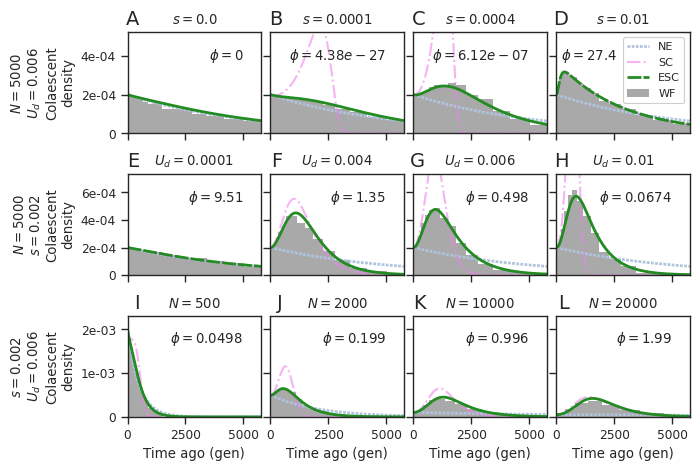

In [20]:
sns.set(style="ticks", context="paper", font_scale=1.0)

nrows, ncols = 3, 4

# fig = plt.figure(figsize=(7.5, 8.75))  # max dimension (PLOS ONE)
figsize_scale = 1
fig = plt.figure(figsize=(7.5 * figsize_scale, 5 * figsize_scale))
gs = fig.add_gridspec(nrows=nrows, ncols=ncols, wspace=0.07, hspace=0.4, left=0.15)

# rows for s variable, U variable, N variable: create ax objects
axs = np.empty((nrows, ncols), dtype=object)
for i, j in np.ndindex(axs.shape):
    axs[i, j] = fig.add_subplot(gs[i, j])


for i, j in np.ndindex(axs.shape):
    ax, (N_, s_, U_) = axs[i, j], parameter_tuples_figure[i, j]
    phi_ = phi(N_, s_, U_)
    if j == 0:
        print("_" * 80)
    print(f"({i}, {j}): $(N={N_}; s={s_}; U_d={U_}), \phi = {phi_}$")
    if j == ncols - 1 and i == nrows - 1:
        print("=" * 80)

    # identify data index
    par_index = (lambda x: x[0] if len(x) else None)(
        np.where(
            (tmrca_index_map.N == N_)
            & (tmrca_index_map.s == s_)
            & (tmrca_index_map.U == U_)
        )[0]
    )

    if not par_index is None:
        # plot simulated
        ax.bar(
            bin_edges_list[par_index][:-1],
            simprobs_list[par_index],
            width=bin_widths_list[par_index],
            align="edge",
            edgecolor="None",
            color="darkgrey",
            label="WF",
        )

        # plot neutral
        ax.plot(
            time_psi,
            neutral_coaldens_df[N_],
            label=f"NE",
            color="lightsteelblue",linestyle=(0, (1, .5)),
            linewidth=2,
        )        

        # plot ND prediction
        if s_ != 0:  # because it calculated the neutral if s was equal to zero; but we plot neutral anyways
            ax.plot(
                time_psi,
                coal_dens_struccoal_list[par_index],
                label=f"SC",
                color="violet",linestyle="-.",
                linewidth=1.5,
                alpha=0.6,
            )

        # plot stepping stone prediction
        ax.plot(
            time_psi,
            coal_dens_stepstone_list[par_index],
            label=f"ESC",
            color="forestgreen",
            linestyle=(0, (5, .75)) if (i,j) == (0,3) or (i,j) == (1,0) else "solid",
            #linestyle="dashed",
            linewidth=2
        )

    # theme
    # ax.axes.get_xaxis().set_visible(False)
    # ax.axes.get_yaxis().set_visible(False)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    if i == 0:
        ax.set_ylim(0, 1.05 * 0.0005)
        #ax.set_xlim(0, 1.05 * 12_000)
    elif i == 1:
        ax.set_ylim(0, 1.05 * 0.0007)
        #ax.set_xlim(0, 1.05 * 7_000)
    elif i == 2:
        ax.set_ylim(0, 1.05 * 0.0022)
        #ax.set_xlim(0, 1.05 * 4_000)
    else:
        sys.exit(f"Unexpected dimension, $row={i}$")
    ax.set_xlim(0, 1.05 * 5_500)
    ax.set_xticks([0, 2500, 5000])

    # overwrite
    #if (i, j) == (2, 0):
    #    ax.set_xlim(0, 1.05 * 2000)

    row_1, row_2, row_3 = [4,5,6,9], [2,3,8,10], [0,1,12,13]
    if not par_index is None:
        #ax.set_title(f"$(N={int(round(N_))}; s={s_}; U_d={U_}), \phi = {phi_}$")
        if i == 0:
            if j == 3:
                ax.text(200, .9*.0005, f"$ \phi = {phi_}$", horizontalalignment='left', verticalalignment="top")
            else:
                ax.text(5000, .9*.0005, f"$ \phi = {phi_}$", horizontalalignment='right', verticalalignment="top")
            ax.set_title(f"$s={s_}$")
        elif i == 1:
            ax.text(5000, .9*0.0007, f"$ \phi = {phi_}$", horizontalalignment='right', verticalalignment="top")
            ax.set_title(f"$U_d={U_}$")
        elif i == 2:
            ax.text(5000, .9*0.0022, f"$ \phi = {phi_}$", horizontalalignment='right', verticalalignment="top")
            ax.set_title(f"$N={int(round(N_))}$")


for index, (i, j) in enumerate(np.ndindex(axs.shape)):
    ax = axs[i, j]
    if j != 0:
        ax.set_yticklabels([])
    if i != 2:
        ax.set_xticklabels([])
    if i == 2:
        ax.set_xlabel("Time ago (gen)")
    if j == 0:
        if i == 0:
            ax.set_ylabel("$N=5000$\n$U_d=0.006$\nColaescent\ndensity")
        elif i == 1:
            ax.set_ylabel("$N=5000$\n$s=0.002$\nColaescent\ndensity")
        elif i == 2:
            ax.set_ylabel("$s=0.002$\n$U_d=0.006$\nColaescent\ndensity")

        def custom_format(value, pos):
            # Use your desired format, adjust it as needed
            if value == 0:
                return "0"
            else:
                return "{:.0e}".format(value)
        
        # Set the custom formatter for the y-axis
        ax.yaxis.set_major_formatter(FuncFormatter(custom_format))

    if (i, j) == (0, 3):
        ax.legend(
            fontsize=8, 
            framealpha=0.95,
            loc="upper right"
        )
    
    # labels
    ax.text(
        0.09,
        1.22,
        string.ascii_uppercase[index],
        transform=ax.transAxes,
        fontsize=14,
        va="top",
        ha="right",
    )


#plt.tight_layout()

plt.show()
plt.close()

________________________________________________________________________________
(0, 0): $(N=5000.0; s=0.0; U_d=0.006), \phi = 0$
(0, 1): $(N=5000.0; s=0.0001; U_d=0.006), \phi = 4.38e-27$
(0, 2): $(N=5000.0; s=0.0004; U_d=0.006), \phi = 6.12e-07$
(0, 3): $(N=5000.0; s=0.01; U_d=0.006), \phi = 27.4$
________________________________________________________________________________
(1, 0): $(N=5000.0; s=0.002; U_d=0.0001), \phi = 9.51$
(1, 1): $(N=5000.0; s=0.002; U_d=0.004), \phi = 1.35$
(1, 2): $(N=5000.0; s=0.002; U_d=0.006), \phi = 0.498$
(1, 3): $(N=5000.0; s=0.002; U_d=0.01), \phi = 0.0674$
________________________________________________________________________________
(2, 0): $(N=500.0; s=0.002; U_d=0.006), \phi = 0.0498$
(2, 1): $(N=2000.0; s=0.002; U_d=0.006), \phi = 0.199$
(2, 2): $(N=10000.0; s=0.002; U_d=0.006), \phi = 0.996$
(2, 3): $(N=20000.0; s=0.002; U_d=0.006), \phi = 1.99$


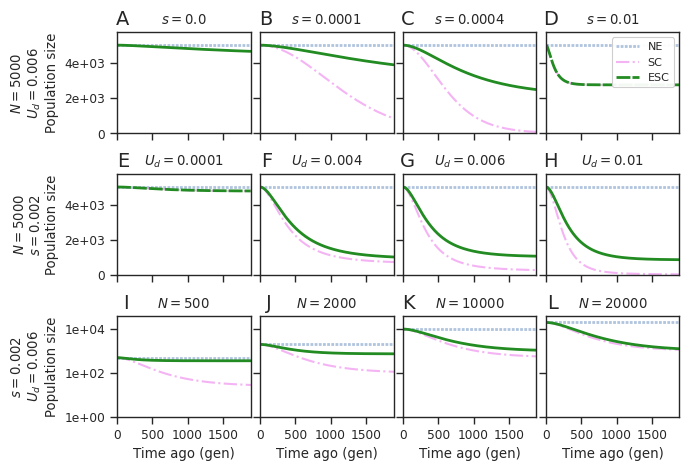

In [21]:
sns.set(style="ticks", context="paper", font_scale=1.0)

nrows, ncols = 3, 4

# fig = plt.figure(figsize=(7.5, 8.75))  # max dimension (PLOS ONE)
figsize_scale = 1
fig2 = plt.figure(figsize=(7.5 * figsize_scale, 5 * figsize_scale))
gs = fig.add_gridspec(nrows=nrows, ncols=ncols, wspace=0.07, hspace=0.4, left=0.15)

# rows for s variable, U variable, N variable: create ax objects
axs = np.empty((nrows, ncols), dtype=object)
for i, j in np.ndindex(axs.shape):
    axs[i, j] = fig2.add_subplot(gs[i, j])


for i, j in np.ndindex(axs.shape):
    ax, (N_, s_, U_) = axs[i, j], parameter_tuples_figure[i, j]
    phi_ = phi(N_, s_, U_)
    if j == 0:
        print("_" * 80)
    print(f"({i}, {j}): $(N={N_}; s={s_}; U_d={U_}), \phi = {phi_}$")
    if j == ncols - 1 and i == nrows - 1:
        print("=" * 80)

    # identify data index
    par_index = (lambda x: x[0] if len(x) else None)(
        np.where(
            (tmrca_index_map.N == N_)
            & (tmrca_index_map.s == s_)
            & (tmrca_index_map.U == U_)
        )[0]
    )

    if not par_index is None:

        # plot neutral
        ax.plot(
            time_psi,
            np.repeat(N_, len(time_psi)),
            label=f"NE",
            color="lightsteelblue",linestyle=(0, (1, .5)),
            linewidth=2,
        )        

        # plot ND prediction
        if s_ != 0:  # because it calculated the neutral if s was equal to zero; but we plot neutral anyways
            ax.plot(
                time_psi,
                effective_popsize_struccoall_list[par_index],
                label=f"SC",
                color="violet",linestyle="-.",
                linewidth=1.5,
                alpha=0.6,
            )

        # plot stepping stone prediction
        ax.plot(
            time_full,
            effective_popsize_stepstone_list[par_index],
            label=f"ESC",
            color="forestgreen",
            linestyle=(0, (5, .75)) if ((i, j) == (0, 3)) or ((i, j) == (1, 0)) else "solid",
            linewidth=2
        )

    # theme
    # ax.axes.get_xaxis().set_visible(False)
    # ax.axes.get_yaxis().set_visible(False)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])

    ax.set_xlim(0, 1.05 * 1_800)
    ax.set_xticks([0, 500, 1000, 1500])

    # overwrite
    if i != 2:
        ax.set_ylim(0, 1.15 * 5000)
    else:
        ax.set_ylim(1, 2.05 * 20000)
        ax.set_yscale("log")

    row_1, row_2, row_3 = [4,5,6,9], [2,3,8,10], [0,1,12,13]
    if not par_index is None:
        #ax.set_title(f"$(N={int(round(N_))}; s={s_}; U_d={U_}), \phi = {phi_}$")
        if i == 0:
            ax.set_title(f"$s={s_}$")
        elif i == 1:
            ax.set_title(f"$U_d={U_}$")
        elif i == 2:
            ax.set_title(f"$N={int(round(N_))}$")


for index, (i, j) in enumerate(np.ndindex(axs.shape)):
    ax = axs[i, j]
    if j != 0:
        ax.set_yticklabels([])

    if i != 2:
        ax.set_xticklabels([])

    if i == 2:
        ax.set_xlabel("Time ago (gen)")

    if j == 0:
        if i == 0:
            ax.set_ylabel("$N=5000$\n$U_d=0.006$\nPopulation size")
        elif i == 1:
            ax.set_ylabel("$N=5000$\n$s=0.002$\nPopulation size")
        elif i == 2:
            ax.set_ylabel("$s=0.002$\n$U_d=0.006$\nPopulation size")

        def custom_format(value, pos):
            # Use your desired format, adjust it as needed
            if value == 0:
                return "0"
            else:
                return "{:.0e}".format(value)
        
        # Set the custom formatter for the y-axis
        ax.yaxis.set_major_formatter(FuncFormatter(custom_format))

    if (i, j) == (0, 3):
        ax.legend(
            fontsize=8, 
            framealpha=0.95,
            loc="upper right"
        )
    
    # labels
    ax.text(
        0.09,
        1.22,
        string.ascii_uppercase[index],
        transform=ax.transAxes,
        fontsize=14,
        va="top",
        ha="right",
    )


#plt.tight_layout()

plt.show()
plt.close()

$(N=5000.0; s=0.0; U_d=0.006)$
$(N=5000.0; s=0.0001; U_d=0.006)$
$(N=5000.0; s=0.0004; U_d=0.006)$
$(N=5000.0; s=0.01; U_d=0.006)$
$(N=5000.0; s=0.002; U_d=0.0001)$
$(N=5000.0; s=0.002; U_d=0.004)$
$(N=5000.0; s=0.002; U_d=0.006)$
$(N=5000.0; s=0.002; U_d=0.01)$
$(N=500.0; s=0.002; U_d=0.006)$
$(N=2000.0; s=0.002; U_d=0.006)$
$(N=10000.0; s=0.002; U_d=0.006)$
$(N=20000.0; s=0.002; U_d=0.006)$


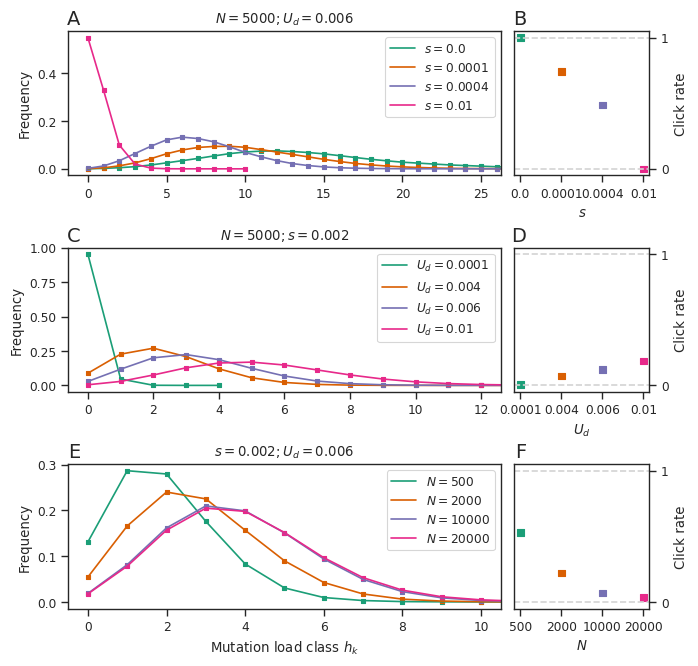

In [22]:
# show profile and click rate
sns.set(style="ticks", context="paper", font_scale=1.0)

my_colors = """
#1b9e77
#d95f02
#7570b3
#e7298a
""".split()

nrows, ncols = 3, 2

# fig = plt.figure(figsize=(7.5, 8.75))  # max dimension (PLOS ONE)
figsize_scale = 1
fig3 = plt.figure(figsize=(7.5 * figsize_scale, 7.5 * figsize_scale))
gs = fig.add_gridspec(nrows=nrows, ncols=4, wspace=0.1, hspace=0.5)

# rows for s variable, U variable, N variable: create ax objects
axs = np.empty((nrows, ncols), dtype=object)
for i, j in np.ndindex(axs.shape):
    if j == 0:
        axs[i, j] = fig3.add_subplot(gs[i, j:3])
    if j == 1:
        axs[i, j] = fig3.add_subplot(gs[i, 3:])


for j in range(3):
    x_par, click_rate_ = [], []
    ax = axs[j, 0]
    for color_index, (N_, s_, U_) in enumerate(parameter_tuples_figure[j,:]):
        print(f"$(N={N_}; s={s_}; U_d={U_})$")
        par_index = (lambda x: x[0] if len(x) else None)(
            np.where(
                (wave_index_map.N == N_)
                & (wave_index_map.s == s_)
                & (wave_index_map.U == U_)
            )[0]
        )

        if j == 0:
            ax.plot(profile_list[par_index].index, profile_list[par_index], label=f"$s={s_}$", color=my_colors[color_index])
            ax.scatter(profile_list[par_index].index, profile_list[par_index], color=my_colors[color_index], marker="s", s=5)
            click_rate_.append(click_rate_list[par_index])
            x_par.append(f"{s_}")

            ax.set_title(f"$N={int(round(N_))}; U_d={U_}$")
        elif j  == 1:
            ax.plot(profile_list[par_index].index, profile_list[par_index], label=f"$U_d={U_}$", color=my_colors[color_index])
            ax.scatter(profile_list[par_index].index, profile_list[par_index], color=my_colors[color_index], marker="s", s=5)
            click_rate_.append(click_rate_list[par_index])
            x_par.append(f"{U_}")

            ax.set_title(f"$N={int(round(N_))}; s={s_}$")
        elif j == 2:
            ax.plot(profile_list[par_index].index, profile_list[par_index], label=f"$N={int(round(N_))}$", color=my_colors[color_index])
            ax.scatter(profile_list[par_index].index, profile_list[par_index], color=my_colors[color_index], marker="s", s=5)
            click_rate_.append(click_rate_list[par_index])
            x_par.append(f"{N_}")

            ax.set_title(f"$s={s_}; U_d={U_}$")
        else:
            sys.exit("#"*300 + " this row was not forseen")
            ax.set_xlim(NoneNone, 1.05 * 12)
        
    # panel B
    ax = axs[j, 1]
    #barlist=ax.bar(x_par, click_rate_)
    if j == 2:
        x_par = np.round([float(_) for _ in x_par], 0).astype(int).astype(str)
    ax.scatter(x_par, click_rate_, color=my_colors, marker="s")
    #_ = [barlist[_].set_color(my_colors[_]) for _ in range(len(x_par))]



for index, (i, j) in enumerate(np.ndindex(axs.shape)):
    ax = axs[i, j]
    
    # labels
    ax.text(
        .09 if j == 1 else 0.0275,
        1.15,
        string.ascii_uppercase[index],
        transform=ax.transAxes,
        fontsize=14,
        va="top",
        ha="right",
    )

    if j == 1:
        ax.set_yticks([0, 1])
        ax.set_ylim(-0.05, 1.05)
        ax.axhline(0, color="lightgray", linestyle="--")
        ax.axhline(1, color="lightgray", linestyle="--")
        #ax.set_xticks([])
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        if i == 0:
            ax.set_xlabel("$s$")
        elif i == 1:
            ax.set_xlabel("$U_d$")
        elif i == 2:
            ax.set_xlabel("$N$")
        ax.set_ylabel("Click rate")

    if j == 0:
        ax.set_ylabel("Frequency")
        ax.legend(
            #fontsize=7
        )

        if i == 0:
            ax.set_xlim(-0.05 * 25, 1.05 * 25)
        elif i == 1:
            ax.set_xlim(-.05 * 12, 1.05 * 12)
        elif i == 2:
            ax.set_xlim(-.05* 10, 1.05 * 10)
        else:
            sys.exit("Unknown row")

    if (i, j) == (2, 0):
        ax.set_xlabel("Mutation load class $h_k$")

#plt.tight_layout()

plt.show()
plt.close()

## Save data and figure

In [23]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure5_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure5_v{version:02d}.png"

plt.figure(fig)
plt.savefig(new_filename, dpi=600)
plt.close()

In [24]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure5_S1_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure5_S1_v{version:02d}.png"

plt.figure(fig2)
plt.savefig(new_filename, dpi=600)
plt.close()

In [25]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure5_S2_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"


new_filename = f"figure5_S2_v{version:02d}.png"

plt.figure(fig3)
plt.savefig(new_filename, dpi=600)
plt.close()